# Modelo de OneClassSVM entrenado con 2F de datos Astro, y predicción sobre datos Unid (no identificados)

**Proyecto**: Detección de posibles fuentes de materia oscura usando ML en datos Fermi-LAT  
**Autor**: Marta Canino Romero  
**Fecha**: febrero-mayo 20225

---

## Descripción:

Este notebook aplica un modelo **One-Class SVM** entrenado con datos de fuentes astrofísicas conocidas (ASTRO) usando las siguientes características:

- E_peak
- beta

Este modelo se entrena para identificar anomalías que puedan corresponder a posibles fuentes de materia oscura (UNIDs) en los datos no identificados del catálogo 4FGL.

---

## Objetivos específicos:

- Entrenar modelo OCSVM con [número de features] 
- Optimizar hiperparámetros (grid search sobre `nu` y `gamma`)
- Evaluar sobre datos de validación y prueba
- Aplicar modelo final sobre datos UNID para predicción

---

## Entrada de datos:

- `../data/astro_df.txt`

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.utils.multiclass import unique_labels

from mpl_toolkits.mplot3d import Axes3D

import warnings

In [2]:
warnings.filterwarnings('ignore')

# Configurar estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
# Cargar dataset
data_path = "../data/astro_df.txt"
df_astro = pd.read_csv(data_path, sep='\s+')
print(f" Nombres de las columnas: {list(df_astro.columns)}")

df_astro = df_astro.rename(columns={"astro_DM": "class"})

print(f" Dataset cargado. Forma: {df_astro.shape}")
print(f" Nombres de las columnas: {list(df_astro.columns)}")

df_astro.head()

 Nombres de las columnas: ['Log(E_peak)', 'Log(beta)', 'Log(sigma)', 'Log(beta_Rel)', 'astro_DM']
 Dataset cargado. Forma: (2831, 5)
 Nombres de las columnas: ['Log(E_peak)', 'Log(beta)', 'Log(sigma)', 'Log(beta_Rel)', 'class']


,Log(E_peak),Log(beta),Log(sigma),Log(beta_Rel),class
0,-0.412502,-1.325139,1.356951,-0.122193,0.0
1,0.708140,-0.000174,0.623167,-1.601886,0.0
2,0.224740,-0.581202,1.010041,-0.311249,0.0
3,0.257319,-0.561933,0.615413,-0.038913,0.0
4,0.326110,-1.100179,1.624932,-0.528753,0.0


In [4]:
# Selección de características
features = ['Log(E_peak)', 'Log(beta)']

"""Establecemos la columna objetivo aunque al ser un problema de detección de anomalías no la utilizaremos para entrenar el modelo.
Además de que todos los datos están etiquetados como 'astro_DM' = 0.0"""
target = 'class'

print(f"Features seleccionadas: {features}")
print(f"Columna objetivo: {target}")

# --- Comprobamos valores nulos ---
print("\n Valores faltantes por columna:")
print(df_astro[features + [target]].isnull().sum())

print("\n Muestra del dataset:")
display(df_astro[features + [target]].head())

Features seleccionadas: ['Log(E_peak)', 'Log(beta)']
Columna objetivo: class

 Valores faltantes por columna:
Log(E_peak)    0
Log(beta)      0
class          0
dtype: int64

 Muestra del dataset:


,Log(E_peak),Log(beta),class
0,-0.412502,-1.325139,0.0
1,0.708140,-0.000174,0.0
2,0.224740,-0.581202,0.0
3,0.257319,-0.561933,0.0
4,0.326110,-1.100179,0.0


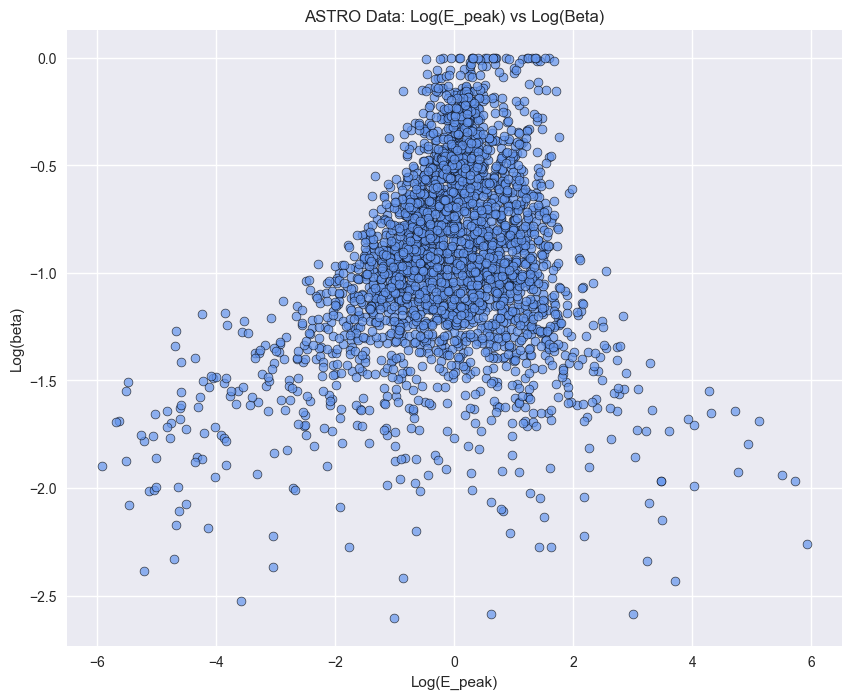

In [ ]:
# Comprobamos la distribución de los datos astro antes de escalar
plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=df_astro,
    x="Log(E_peak)",
    y="Log(beta)",
    color="cornflowerblue",  # "skyblue", "turquoise", "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40
)

plt.title("ASTRO Data: Log(E_peak) vs Log(Beta)")
plt.xlabel("Log(E_peak)")
plt.ylabel("Log(beta)")
plt.grid(True)
plt.show()

In [6]:
X = df_astro[features].values
y = df_astro[target].values

# SPLIT: Train / Val / Test
# 60% train, 20% val, 20% test
# de esta manera, el test set no se ve en el entrenamiento
# y el val set se usa para ajustar los hiperparámetros)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Escalamos los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [7]:
print("Forma de X_train_scaled:", X_train_scaled.shape)
print("Forma de X_val_scaled:"  , X_val_scaled.shape)
print("Forma de X_test_scaled:", X_test_scaled.shape)

Forma de X_train_scaled: (1698, 2)
Forma de X_val_scaled: (566, 2)
Forma de X_test_scaled: (567, 2)


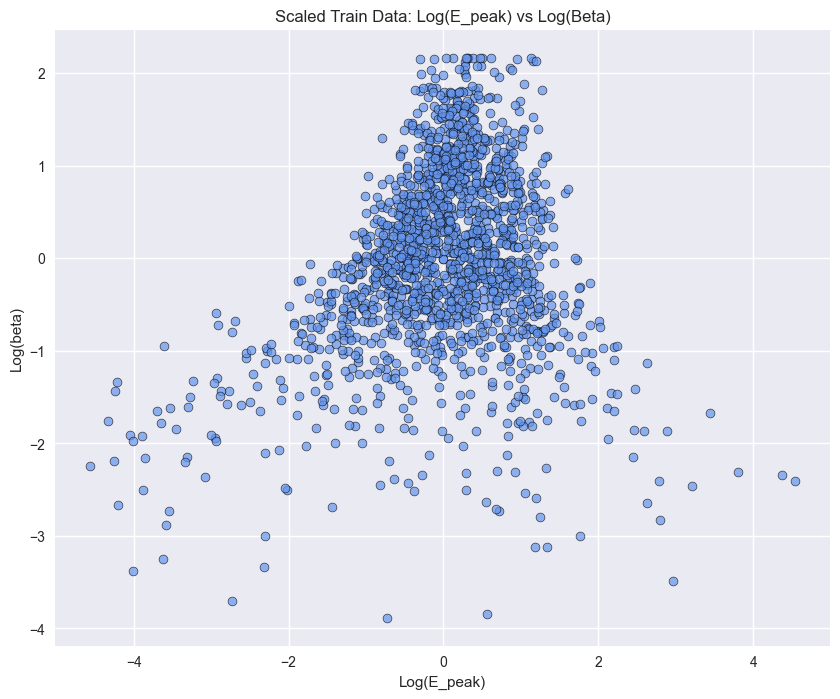

In [8]:
# Comprobamos que los datos están bien escalados
plt.figure(figsize=(10, 8))

sns.scatterplot(
    x=X_train_scaled[:, 0],
    y=X_train_scaled[:, 1],
    color="cornflowerblue",  # "skyblue" "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40
)
plt.title("Scaled Train Data: Log(E_peak) vs Log(Beta)")
plt.xlabel("Log(E_peak)")
plt.ylabel("Log(beta)")
plt.grid(True)
plt.show()


In [9]:
# Hiperparámetros a explorar
nu_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05]
# gamma_values = ['scale', 'auto'] + list(np.logspace(-4, 2, 7))
# gamma_values = ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10]
# gamma_values = ['scale', 'auto'] + list(np.logspace(-3, 1, 5))
gamma_values = [0.1]

# Tracking
results = []
best_outliers = np.inf
best_model = None
best_params = {}

# --- Grid Search ---

print("Buscando hiperparámetros que minimicen outliers en ASTRO (validación)...")

for nu in nu_values:
    for gamma in gamma_values:
        model = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
        model.fit(X_train_scaled)

        # Predicciones
        preds_val = model.predict(X_val_scaled)  # 1 = normal, -1 = outlier
        pred_labels = np.where(preds_val == 1, 0, 1)         # Mapear a 0 = normal, 1 = anomalía
        true_labels = y_val.astype(int)                  # Aseguramos tipo int
        n_outliers = np.sum(preds_val == -1)
        # f1 = f1_score(true_labels, pred_labels, pos_label=0)

        results.append({'nu': nu, 'gamma': gamma, 'val_outliers': n_outliers})

        """
        if f1 > best_score:
            best_score = f1
            best_model = model
            best_params = {'nu': nu, 'gamma': gamma}
        """
        if n_outliers < best_outliers:
            best_outliers = n_outliers
            best_model = model
            best_params = {'nu': nu, 'gamma': gamma}

# Mostrar resultado óptimo
print(f"\n Mejor combinación de hiperparámetros:")
print(f"   - ν = {best_params['nu']}")
print(f"   - γ = {best_params['gamma']}")
print(f"Outliers (val set): {best_outliers} de {len(X_val_scaled)} muestras")

df_results = pd.DataFrame(results)
display(df_results.sort_values(by='val_outliers'))

Buscando hiperparámetros que minimicen outliers en ASTRO (validación)...

 Mejor combinación de hiperparámetros:
   - ν = 0.001
   - γ = 0.1
Outliers (val set): 3 de 566 muestras


,nu,gamma,val_outliers
0,0.001,0.1,3
1,0.002,0.1,3
2,0.005,0.1,4
3,0.010,0.1,8
4,0.020,0.1,19
5,0.050,0.1,36


In [10]:
"""# Evaluar el modelo en el conjunto de validación
val_preds = best_model.predict(X_val_scaled)
n_val_outliers = np.sum(val_preds == -1)
print(f"Outliers (val set): {n_val_outliers} de {len(X_val_scaled)} muestras")

# Evaluar el modelo en el conjunto de test
# (no se ha visto en el entrenamiento)
test_preds = best_model.predict(X_test_scaled)
n_test_outliers = np.sum(test_preds == -1)
print(f"Outliers (test set): {n_test_outliers} de {len(X_test_scaled)} muestras")"""

'# Evaluar el modelo en el conjunto de validación\nval_preds = best_model.predict(X_val_scaled)\nn_val_outliers = np.sum(val_preds == -1)\nprint(f"Outliers (val set): {n_val_outliers} de {len(X_val_scaled)} muestras")\n\n# Evaluar el modelo en el conjunto de test\n# (no se ha visto en el entrenamiento)\ntest_preds = best_model.predict(X_test_scaled)\nn_test_outliers = np.sum(test_preds == -1)\nprint(f"Outliers (test set): {n_test_outliers} de {len(X_test_scaled)} muestras")'

In [ ]:
# Reentrenar con X_train + X_val
X_final_train = np.vstack([X_train, X_val])
y_final_train = np.concatenate([y_train, y_val])

scaler_final = StandardScaler()
X_final_train_scaled = scaler_final.fit_transform(X_final_train)
X_test_scaled = scaler_final.transform(X_test)

# Entrenar modelo final
final_model = OneClassSVM(kernel='rbf', nu=best_params['nu'], gamma=best_params['gamma'])
final_model.fit(X_final_train_scaled)

OneClassSVM(gamma=0.1, nu=0.001)

In [12]:
# Evaluar en test
test_preds = final_model.predict(X_test_scaled)
test_labels = np.where(test_preds == 1, 0, 1)

# Metricas
print(f"\n Evaluación en el conjunto de test:")
print(f"Outliers (test set): {np.sum(test_preds == -1)} de {len(X_test_scaled)} muestras")

print(f"\n Matriz de confusión:")
cm = confusion_matrix(y_test, test_labels)
print(cm)
print(f"\n Reporte de clasificación:")
print(classification_report(y_test, test_labels, target_names=unique_labels(y_test, test_labels).astype(str)))


 Evaluación en el conjunto de test:
Outliers (test set): 5 de 567 muestras

 Matriz de confusión:
[[562   5]
 [  0   0]]

 Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       567
         1.0       0.00      0.00      0.00         0

    accuracy                           0.99       567
   macro avg       0.50      0.50      0.50       567
weighted avg       1.00      0.99      1.00       567



<Axes: ylabel='Count'>

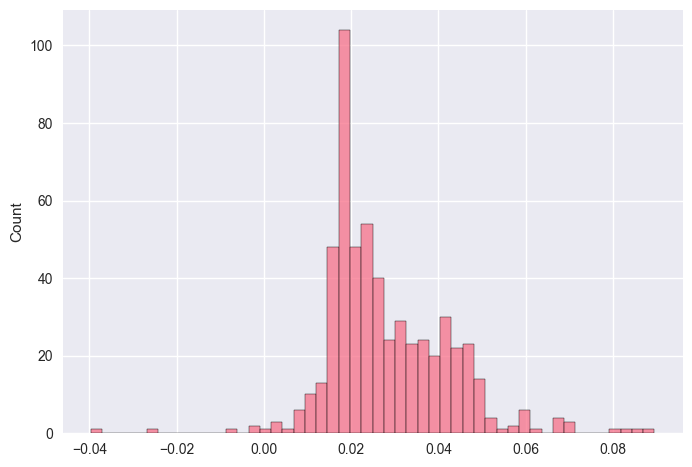

In [13]:
scores = final_model.decision_function(X_test_scaled)

sns.histplot(scores, bins=50)

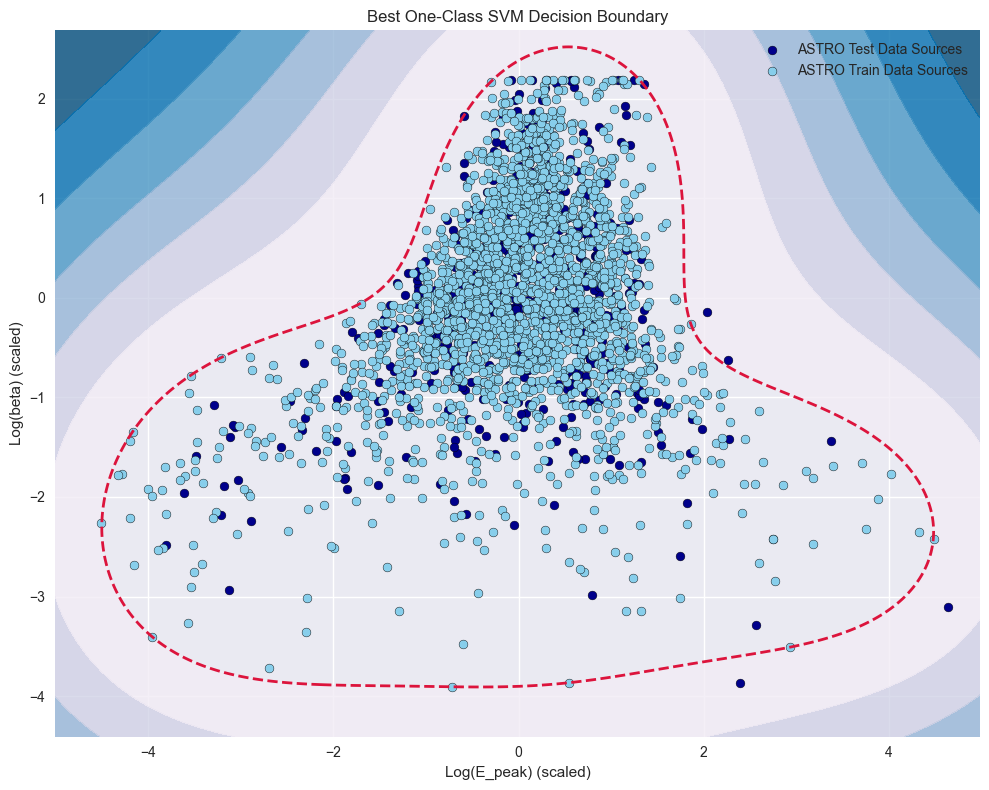

In [14]:
xx, yy = np.meshgrid(
    np.linspace(X_final_train_scaled[:, 0].min() - 0.5, X_final_train_scaled[:, 0].max() + 0.5, 300),  # Log(E_peak)
    np.linspace(X_final_train_scaled[:, 1].min() - 0.5, X_final_train_scaled[:, 1].max() + 0.5, 300)   # Log(beta)
)

grid = np.c_[xx.ravel(), yy.ravel()]

Z = final_model.decision_function(grid)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu_r, alpha=0.8)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='crimson', linestyles='--')

# Plot training and test data
plt.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c='darkblue', edgecolors='k', s=40, label='ASTRO Test Data Sources')
plt.scatter(X_final_train_scaled[:, 0], X_final_train_scaled[:, 1], c='skyblue', edgecolors='k', s=40, label='ASTRO Train Data Sources')

plt.xlabel("Log(E_peak) (scaled)")
plt.ylabel("Log(beta) (scaled)")
plt.title("Best One-Class SVM Decision Boundary")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


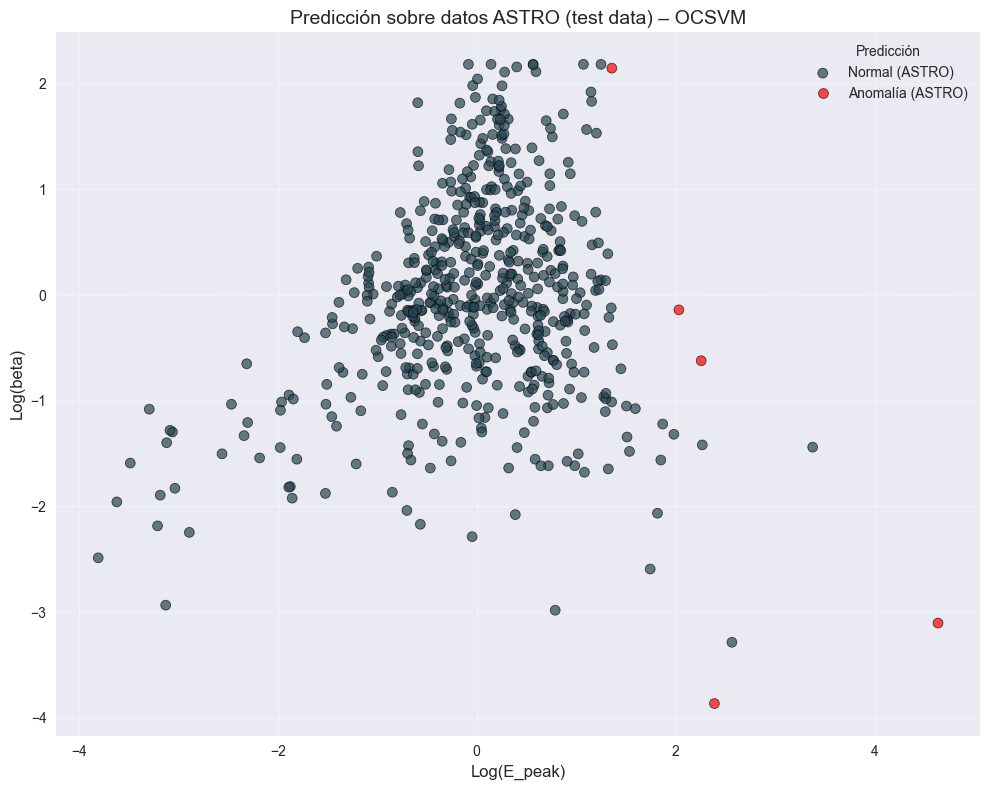

In [15]:
plt.figure(figsize=(10, 8))

# Colores mejorados
palette = {
    1: '#264653',   # ASTRO normal (azul petróleo)
    -1: 'red'   # ASTRO outlier (rojo)
}

sns.scatterplot(
    x=X_test_scaled[:, 0],
    y=X_test_scaled[:, 1],
    hue=test_preds,
    palette=palette,
    edgecolor='k',
    alpha=0.7,
    s=50,
    marker='o'
)

plt.title("Predicción sobre datos ASTRO (test data) – OCSVM", fontsize=14)
plt.xlabel("Log(E_peak)", fontsize=12)
plt.ylabel("Log(beta)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(
    title="Predicción",
    loc='upper right',
    labels=["Normal (ASTRO)", "Anomalía (ASTRO)"],
    fontsize=10
)
plt.tight_layout()
plt.show()


# Predict on UNIDs

In [16]:
# unids_path = "../../data/raw/unids_3F_beta_err_names.txt"
unids_path = "../data/unids_log.txt"
df_unids = pd.read_csv(unids_path, sep='\s+')
df_unids.head()

,Log(E_peak),Log(beta),Log(sigma_det),Log(beta_Rel),number
0,0.400175,-1.047208,0.869208,0.212452,0
1,0.169733,-0.380594,0.733598,-0.113037,1
2,0.203142,-0.168578,1.033058,-0.430366,2
3,-0.031074,-0.557363,0.881133,-0.201588,3
4,-0.351835,-0.493901,0.630916,-0.246028,4


In [17]:
# Extraer y escalar 
X_unids_log = df_unids[["Log(E_peak)", "Log(beta)"]].values
X_unids_scaled = scaler.transform(X_unids_log)

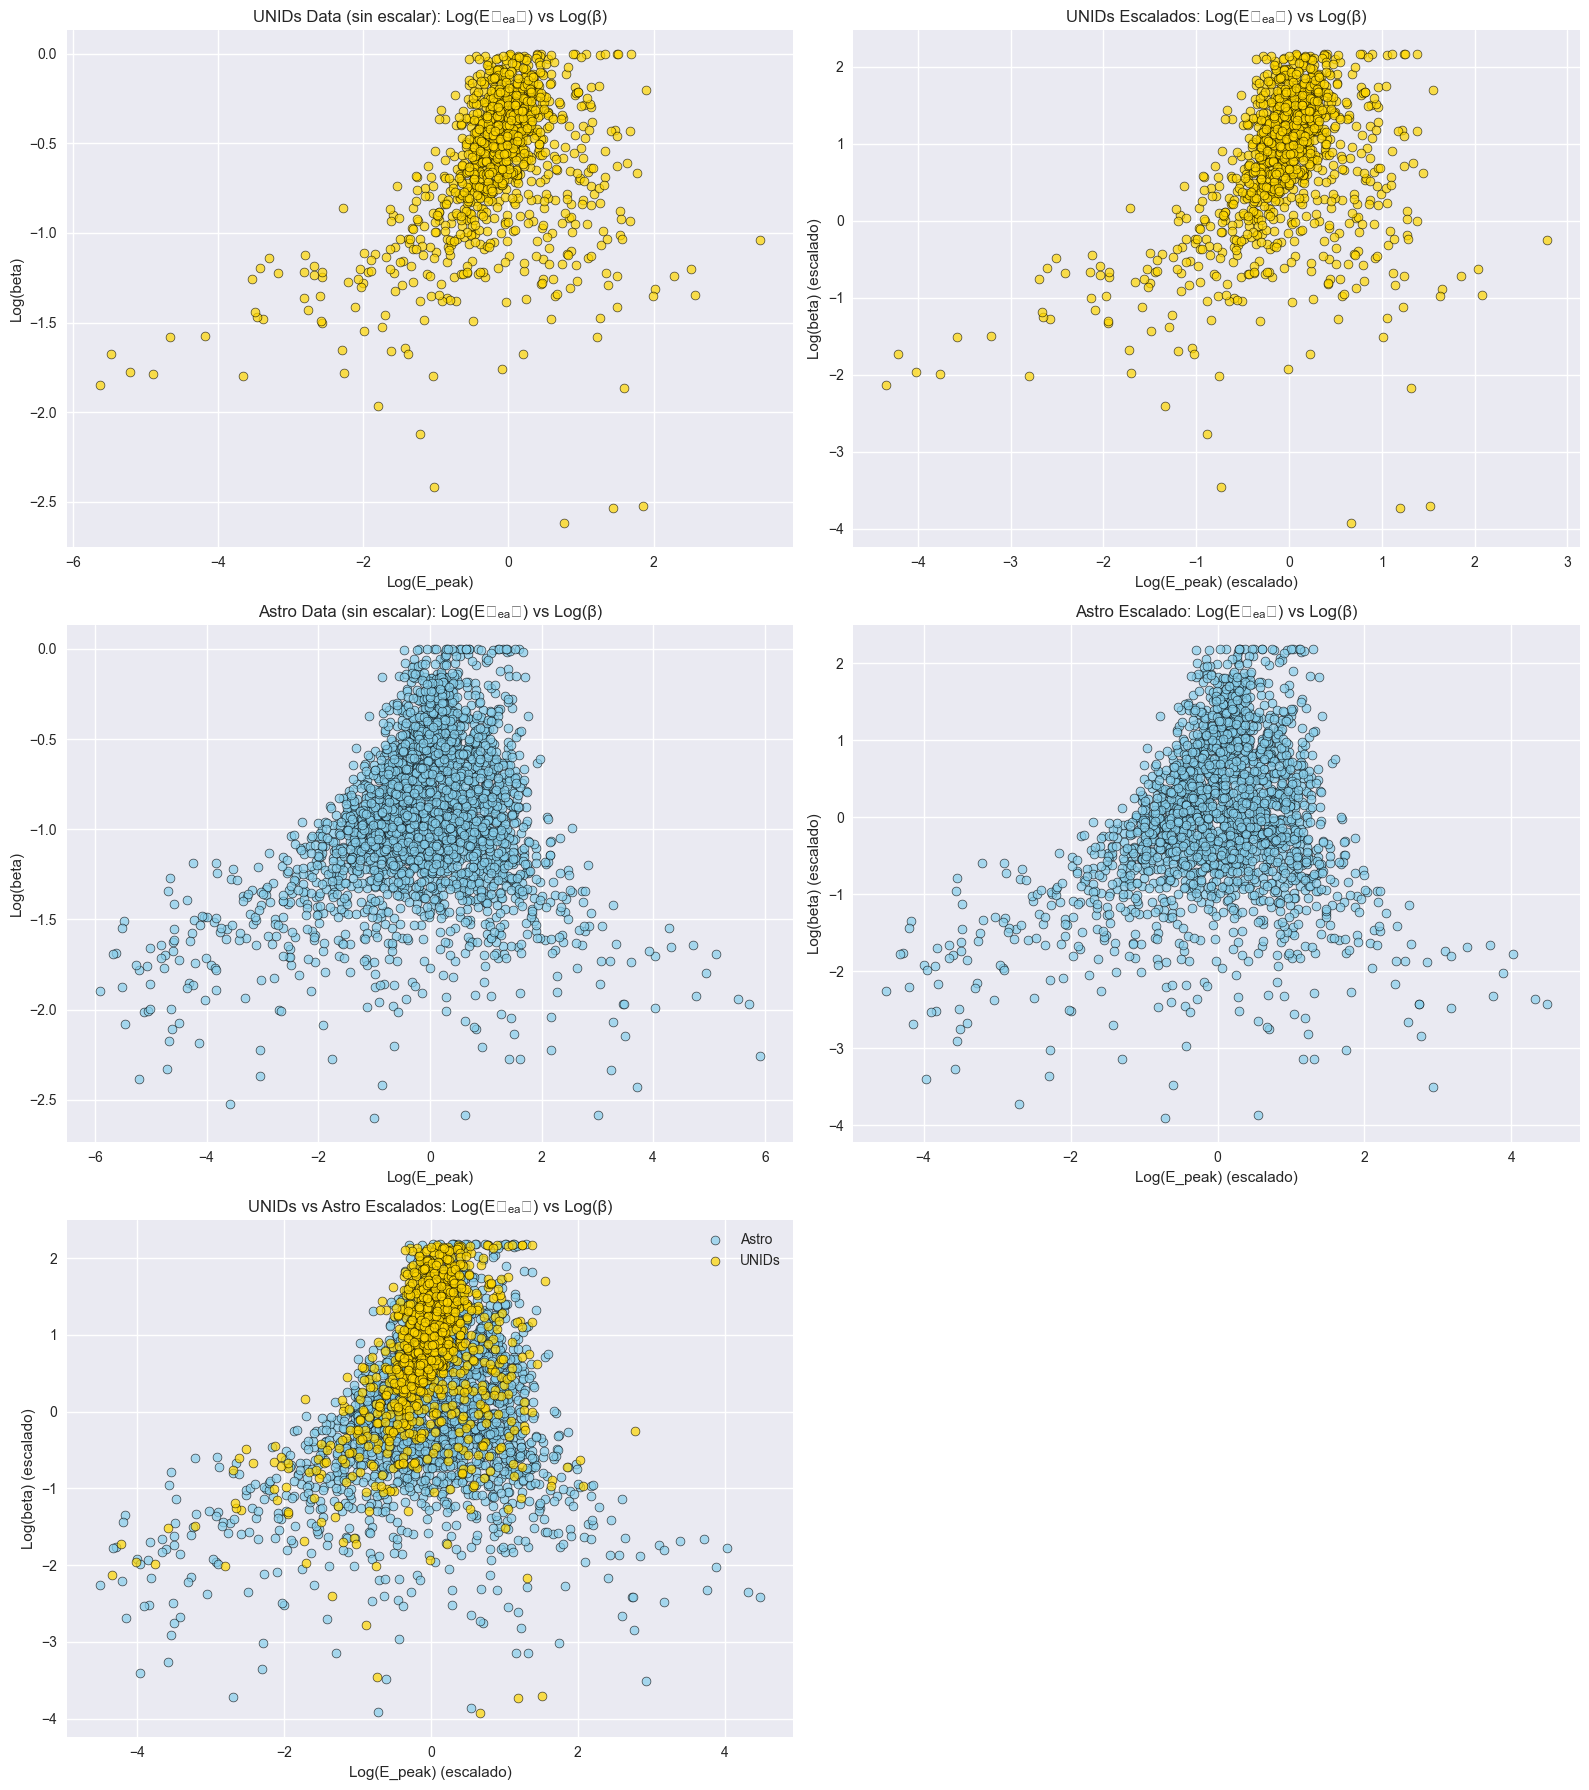

In [18]:
# --- Crear subplots 3x2 ---
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# --- Plot 1: UNIDs sin escalar ---
sns.scatterplot(
    data=df_unids,
    x="Log(E_peak)",
    y="Log(beta)",
    color="gold",
    edgecolor='k',
    alpha=0.7,
    s=40,
    ax=axes[0, 0]
)
axes[0, 0].set_title("UNIDs Data (sin escalar): Log(Eₚₑₐₖ) vs Log(β)")
axes[0, 0].set_xlabel("Log(E_peak)")
axes[0, 0].set_ylabel("Log(beta)")
axes[0, 0].grid(True)

# --- Plot 2: UNIDs escalados ---
sns.scatterplot(
    x=X_unids_scaled[:, 0],
    y=X_unids_scaled[:, 1],
    color="gold",
    edgecolor='k',
    alpha=0.7,
    s=40,
    ax=axes[0, 1]
)
axes[0, 1].set_title("UNIDs Escalados: Log(Eₚₑₐₖ) vs Log(β)")
axes[0, 1].set_xlabel("Log(E_peak) (escalado)")
axes[0, 1].set_ylabel("Log(beta) (escalado)")
axes[0, 1].grid(True)

# --- Plot 3: Astro sin escalar ---
sns.scatterplot(
    data=df_astro,  # asegúrate de tener este DataFrame cargado
    x="Log(E_peak)",
    y="Log(beta)",
    color="skyblue",
    edgecolor='k',
    alpha=0.7,
    s=40,
    ax=axes[1, 0]
)
axes[1, 0].set_title("Astro Data (sin escalar): Log(Eₚₑₐₖ) vs Log(β)")
axes[1, 0].set_xlabel("Log(E_peak)")
axes[1, 0].set_ylabel("Log(beta)")
axes[1, 0].grid(True)

# --- Plot 4: Astro escalado ---
sns.scatterplot(
    x=X_final_train_scaled[:, 0],
    y=X_final_train_scaled[:, 1],
    color="skyblue",
    edgecolor='k',
    alpha=0.7,
    s=40,
    ax=axes[1, 1]
)
axes[1, 1].set_title("Astro Escalado: Log(Eₚₑₐₖ) vs Log(β)")
axes[1, 1].set_xlabel("Log(E_peak) (escalado)")
axes[1, 1].set_ylabel("Log(beta) (escalado)")
axes[1, 1].grid(True)

# --- Plot 5: Comparación UNIDs vs Astro escalados ---
sns.scatterplot(
    x=X_final_train_scaled[:, 0],
    y=X_final_train_scaled[:, 1],
    color="skyblue",
    edgecolor='k',
    alpha=0.7,
    s=40,
    label='Astro',
    ax=axes[2, 0]
)
sns.scatterplot(
    x=X_unids_scaled[:, 0],
    y=X_unids_scaled[:, 1],
    color="gold",
    edgecolor='k',
    alpha=0.7,
    s=40,
    label='UNIDs',
    ax=axes[2, 0]
)
axes[2, 0].set_title("UNIDs vs Astro Escalados: Log(Eₚₑₐₖ) vs Log(β)")
axes[2, 0].set_xlabel("Log(E_peak) (escalado)")
axes[2, 0].set_ylabel("Log(beta) (escalado)")
axes[2, 0].legend()
axes[2, 0].grid(True)

# --- Eliminar celda vacía (3,2) ---
fig.delaxes(axes[2, 1])

# --- Layout final ---
plt.tight_layout()
plt.show()


In [19]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [20]:
# Predecir sobre unids usando el mejor modelo
unids_preds = final_model.predict(X_unids_scaled)
# unids_preds = best_model.predict(X_unids_scaled)
unids_labels = np.where(unids_preds == 1, 0, 1)  # 1→normal, -1→outlier

n_outliers = np.sum(unids_preds == -1)
n_normals = np.sum(unids_preds == 1)

print(f"Predicted ASTRO-like: {n_normals}")
print(f"Predicted not ASTRO-like (anomalies): {n_outliers}")

# Añadir etiquetas al DataFrame
df_unids['pred_labels'] = unids_labels

# Filtrar los datos no clasificados
# df_unids['pred_labels'] = df_unids['pred_labels'].astype(int)
# df_unids['pred_labels'] = df_unids['pred_labels'].replace({0: 'Normal', 1: 'Anomalía'})

df_unids.sample(10, random_state=42)


Predicted ASTRO-like: 1121
Predicted not ASTRO-like (anomalies): 4


,Log(E_peak),Log(beta),Log(sigma_det),Log(beta_Rel),number,pred_labels
1089,0.809950,-1.119758,0.779697,0.135537,1089,0
1103,1.679164,-0.932185,1.019029,-0.427333,1103,0
739,-0.073164,-0.289713,0.655532,-0.208817,739,0
140,-2.261600,-1.779892,1.084834,0.586750,140,0
1018,-0.765533,-0.746904,0.849278,-0.152725,1018,0
527,0.260834,-0.025350,0.727679,-0.422225,527,0
812,0.139816,-0.435097,0.690214,-0.454987,812,0
481,-0.429445,-0.847712,1.381238,-0.465652,481,0
1118,-0.064664,-0.561141,0.979758,-0.350723,1118,0
950,0.120771,-0.163233,0.717762,-0.326759,950,0


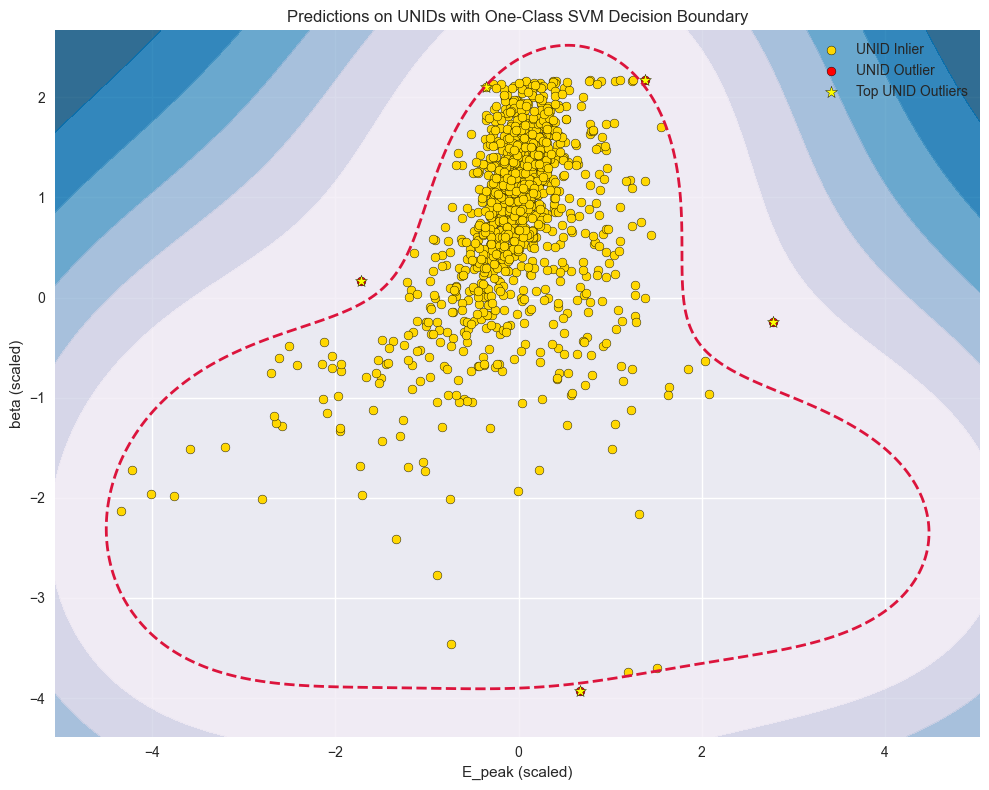

In [21]:
# Create meshgrid (with correct feature order: [beta, E_peak])
xx, yy = np.meshgrid(
    np.linspace(X_train_scaled[:, 0].min() - 0.5, X_train_scaled[:, 0].max() + 0.5, 300),  # E_peak
    np.linspace(X_train_scaled[:, 1].min() - 0.5, X_train_scaled[:, 1].max() + 0.5, 300)   # beta
)

grid = np.c_[xx.ravel(), yy.ravel()]
Z = final_model.decision_function(grid)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu_r, alpha=0.8)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='crimson', linestyles='--')

preds_unids = final_model.predict(X_unids_scaled)
inliers = X_unids_scaled[preds_unids == 1]
outliers = X_unids_scaled[preds_unids == -1]

plt.scatter(inliers[:, 0], inliers[:, 1], c='gold', edgecolors='k', s=40, label='UNID Inlier')
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', edgecolors='k', s=40, label='UNID Outlier')

# Highlight most anomalous UNIDs using their lowest decision score:
decision_scores = final_model.decision_function(X_unids_scaled)
# Optional: mark top 5 most anomalous
top_anomalies = X_unids_scaled[np.argsort(decision_scores)[:5]]
plt.scatter(top_anomalies[:, 0], top_anomalies[:, 1], c='yellow', edgecolors='black', s=80, label='Top UNID Outliers', marker='*')


# Plot training and test data
# plt.scatter(X_train_scaled[:, 1], X_train_scaled[:, 0], c='skyblue', edgecolors='k', s=40, label='ASTRO (Train)')
# plt.scatter(X_unids_scaled[:, 1], X_unids_scaled[:, 0], c='orchid', edgecolors='k', s=40, label='Test')
# plt.scatter(X_unids_scaled[:, 1], X_unids_scaled[:, 0], c='tomato', edgecolors='k', s=40, label='UNIDs')


plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.title("Predictions on UNIDs with One-Class SVM Decision Boundary")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


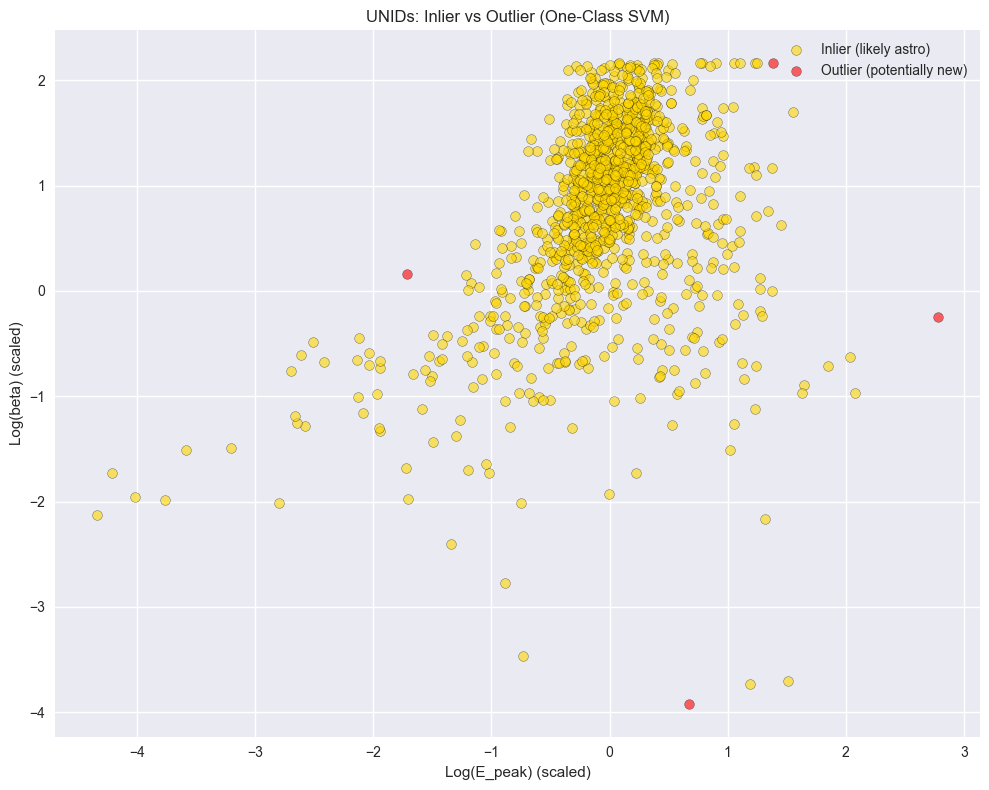

In [22]:
inliers = X_unids_scaled[unids_preds == 1]
outliers = X_unids_scaled[unids_preds == -1]

plt.figure(figsize=(10, 8))
plt.scatter(inliers[:, 0], inliers[:, 1], c='gold', edgecolors='k', label='Inlier (likely astro)', alpha=0.6)
plt.scatter(outliers[:, 0], outliers[:,1], c='red', edgecolors='k', label='Outlier (potentially new)', alpha=0.6)

plt.xlabel("Log(E_peak) (scaled)")
plt.ylabel("Log(beta) (scaled)")
plt.title("UNIDs: Inlier vs Outlier (One-Class SVM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Anomaly Scoring - UNIDs

In [23]:
# Evaluar cada muestra no identificada con el modelo entrenado
# decision_function devuelve un valor continuo: cuanto más alto, más normal (positivo); cuanto más bajo, más anómalo (negativo)
decision_scores = final_model.decision_function(X_unids_scaled)  # X_unids_scaled = muestras no etiquetadas, ya escaladas

#Predecir si cada punto es inlier (1) o outlier (-1)
unids_preds = final_model.predict(X_unids_scaled)  # 1 = normal, -1 = anomalía


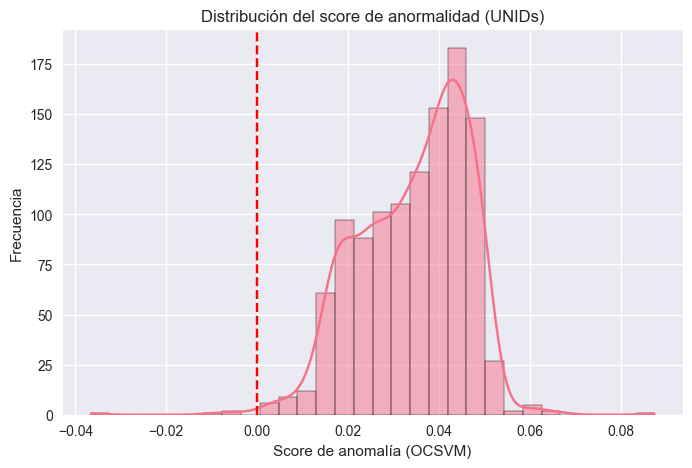

In [24]:
plt.figure(figsize=(8,5))
sns.histplot(decision_scores, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribución del score de anormalidad (UNIDs)')
plt.xlabel('Score de anomalía (OCSVM)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [25]:

df_unids['Anomaly_score'] = decision_scores
top_anomalous = df_unids.sort_values('Anomaly_score').head(10)
display(top_anomalous)

,Log(E_peak),Log(beta),Log(sigma_det),Log(beta_Rel),number,pred_labels,Anomaly_score
1054,3.469896,-1.037631,0.679664,0.317981,1054,1,-0.036636
275,-2.278140,-0.862013,0.806424,-0.002854,275,1,-0.009451
1116,0.771404,-2.619789,0.747319,1.599337,1116,1,-0.005686
1017,1.682984,-0.000087,0.632690,-1.191027,1017,1,-0.003810
1043,-0.537962,-0.029467,0.735990,-0.559081,1043,0,0.001080
126,1.852297,-2.522879,1.366374,0.721536,126,0,0.002199
592,2.516271,-1.203426,0.782766,0.242840,592,0,0.002587
1111,-1.536062,-0.738737,0.767282,-0.088077,1111,0,0.002763
273,-0.445668,-0.014529,0.761943,-0.530474,273,0,0.003307
564,1.438969,-2.537602,0.865797,1.397940,564,0,0.003314


In [26]:
# Agregar los resultados al DataFrame original
df_unids["svm_score"] = decision_scores       # Puntaje bruto del modelo (positivo = normal)
df_unids["prediction"] = unids_preds          # Clasificación binaria: inlier o outlier

# Invertimos el score para que valores más altos signifiquen más anomalía
# Esto es útil para poder escalar la puntuación y ordenar más intuitivamente
anom_scores = -decision_scores  # Ahora, valores grandes = más anómalos

# Escalamos los scores de anomalía al rango [0, 100] para facilitar su interpretación
anom_percent = MinMaxScaler(feature_range=(0, 100)).fit_transform(anom_scores.reshape(-1, 1)).flatten()

# Guardamos el puntaje invertido y su porcentaje normalizado en el DataFrame
df_unids["(-)Anomaly_Score"] = anom_scores
df_unids["Anomaly_Rank(%)"] = anom_percent  # 100 = más anómalo, 0 = más normal

# Paso 6: Filtramos solo los puntos predichos como anómalos y los ordenamos por su score más alto
top_anomalies = df_unids[df_unids["prediction"] == -1] \
                    .sort_values(by="Anomaly_Rank(%)", ascending=False) \
                    .head(10)

# Guardamos los índices (puede ser útil si queremos recuperar sus posiciones originales)
most_anomalous_idx = top_anomalies.index

# Guardamos los 10 más anómalos en un archivo
top_anomalies.to_csv("../data/results/ocsvm/2F/ocsvm_unids_most_anomalous_2F.txt", sep="\t", index=False)

# Mostramos en pantalla un resumen de las anomalías detectadas
print("Top Most Anomalous UNID Sources (4F One-Class SVM):")
display(top_anomalies[['number', 'svm_score', 'Anomaly_score', '(-)Anomaly_Score', 'Anomaly_Rank(%)']])

Top Most Anomalous UNID Sources (4F One-Class SVM):


,number,svm_score,Anomaly_score,(-)Anomaly_Score,Anomaly_Rank(%)
1054,1054,-0.036636,-0.036636,0.036636,100.000000
275,275,-0.009451,-0.009451,0.009451,78.078019
1116,1116,-0.005686,-0.005686,0.005686,75.041503
1017,1017,-0.003810,-0.003810,0.003810,73.528997


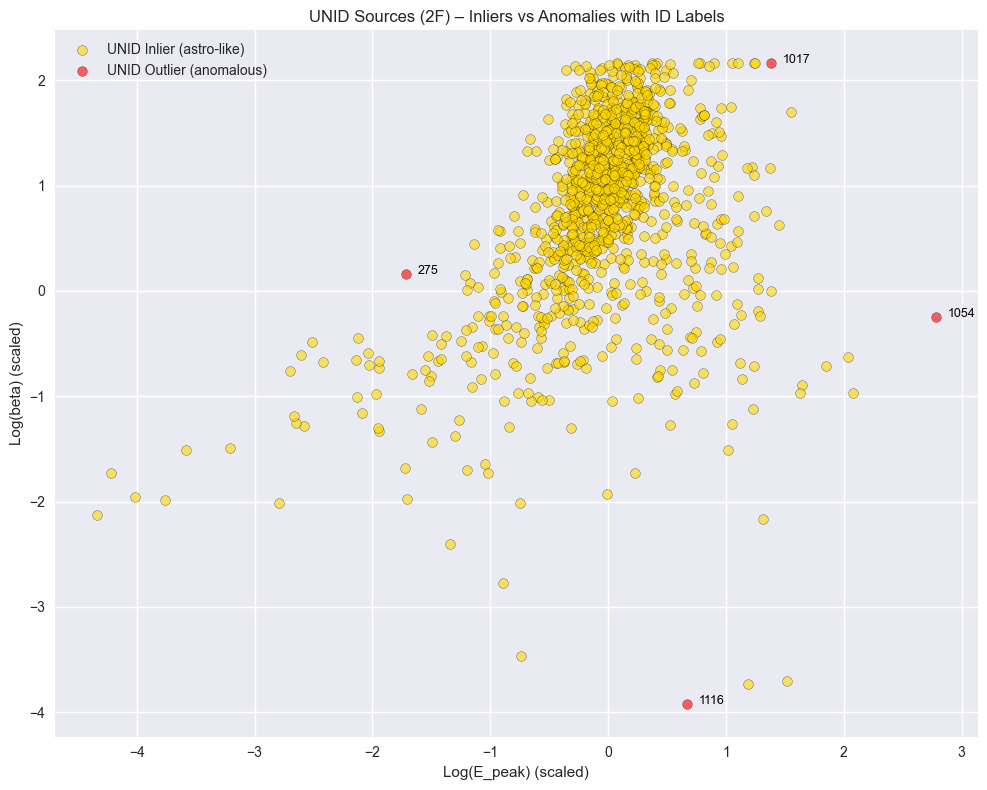

In [27]:
plt.figure(figsize=(10, 8))

# Inliers and outliers from scaled data
inliers = X_unids_scaled[unids_preds == 1]
outliers = X_unids_scaled[unids_preds == -1]

# Plot inliers (gold)
plt.scatter(inliers[:, 0], inliers[:, 1], c='gold', edgecolors='k', label='UNID Inlier (astro-like)', alpha=0.6)

# Plot outliers (red)
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', edgecolors='k', label='UNID Outlier (anomalous)', alpha=0.6)

# Annotate top 10 anomalies by ID
for idx in most_anomalous_idx:
    x = X_unids_scaled[idx, 0]  # E_peak (scaled)
    y = X_unids_scaled[idx, 1]  # beta (scaled)
    label = int(df_unids.loc[idx, 'number'])
    plt.text(x + 0.1, y, str(label), color='black', fontsize=9)

# Axis labels and styling
plt.xlabel("Log(E_peak) (scaled)")
plt.ylabel("Log(beta) (scaled)")
plt.title("UNID Sources (2F) – Inliers vs Anomalies with ID Labels")
plt.legend()
plt.grid(True)
plt.tight_layout()

# plt.savefig("../outputs/figures/ocsvm/2F/2F_UNIDs_OneClassSVM_2D_scaled.png", dpi=300, bbox_inches='tight')

plt.show()


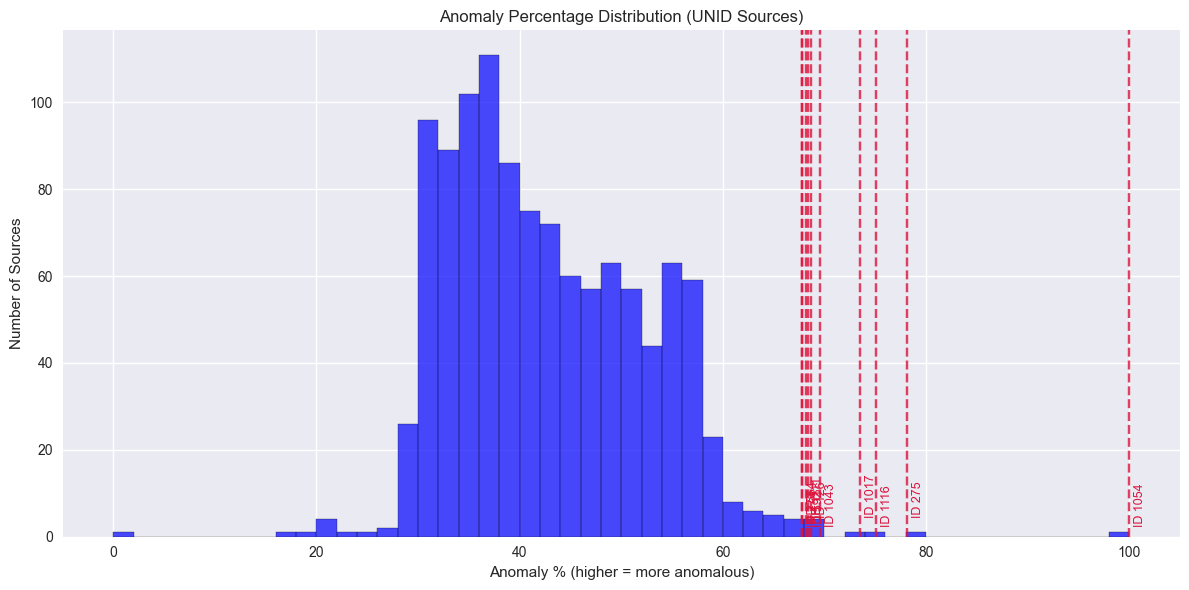

In [28]:

# Sort anomaly scores and grab top N labels
N = 10
sorted_idx = np.argsort(-anom_percent)  # high anomaly % = more anomalous
top_N_idx = sorted_idx[:N]

top_labels = df_unids.iloc[top_N_idx]['number'].astype(str).values
top_scores = anom_percent[top_N_idx]

plt.figure(figsize=(12, 6))
plt.hist(anom_percent, bins=50, color='blue', edgecolor='k', alpha=0.7)
plt.title("Anomaly Percentage Distribution (UNID Sources)")
plt.xlabel("Anomaly % (higher = more anomalous)")
plt.ylabel("Number of Sources")

for i in range(N):
    x = top_scores[i]
    label = top_labels[i]
    plt.axvline(x, color='crimson', linestyle='--', alpha=0.8)
    plt.text(x + 0.5, 3 + (i % 2) * 2, f"ID {label}", rotation=90, color='crimson', ha='left', fontsize=9)

plt.grid(True)
plt.tight_layout()
plt.show()


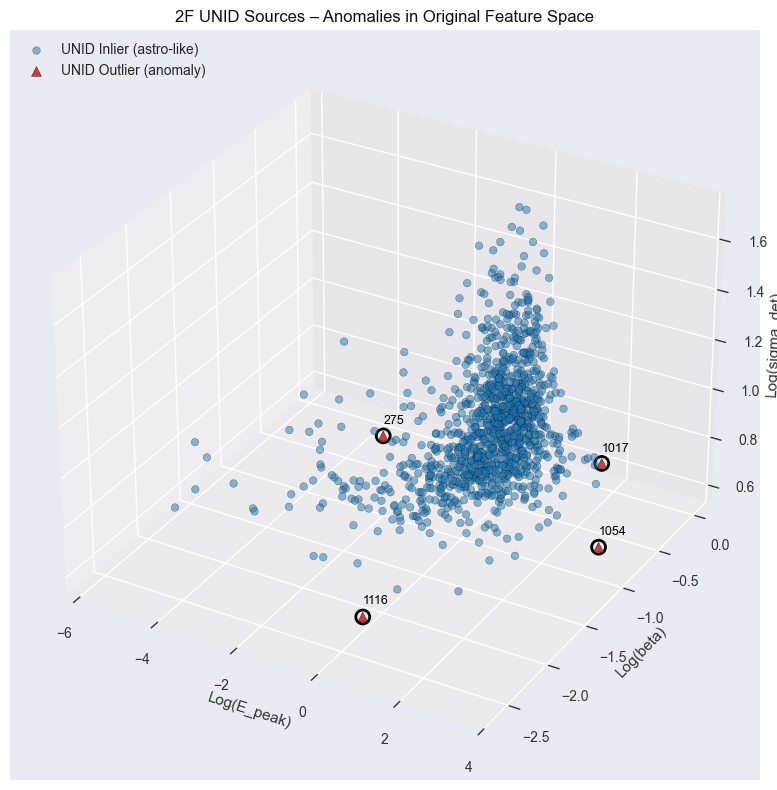

In [29]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Original/log-transformed values for 3 relevant features
x_vals = df_unids['Log(E_peak)'].values
y_vals = df_unids['Log(beta)'].values
z_vals = df_unids['Log(sigma_det)'].values  # or 'Log(beta_Rel)' for 3F.2

# Use model predictions for coloring
inlier_idx = df_unids['prediction'] == 1
outlier_idx = df_unids['prediction'] == -1

# Inliers
ax.scatter(
    x_vals[inlier_idx], y_vals[inlier_idx], z_vals[inlier_idx],
    c='#1f77b4', edgecolor='k', s=30, label='UNID Inlier (astro-like)', alpha=0.5
)

# Outliers
ax.scatter(
    x_vals[outlier_idx], y_vals[outlier_idx], z_vals[outlier_idx],
    c='#d62728', marker='^', edgecolor='k', s=50, label='UNID Outlier (anomaly)', alpha=0.9
)

# Annotate top anomalies
top_anomalies = df_unids[df_unids['prediction'] == -1].sort_values('Anomaly_Rank(%)', ascending=False).head(10)
for idx in top_anomalies.index:
    ax.scatter(
        x_vals[idx], y_vals[idx], z_vals[idx],
        facecolors='none', edgecolors='black', linewidths=2, s=100
    )
    ax.text(
        x_vals[idx], y_vals[idx], z_vals[idx] + 0.05,
        str(int(df_unids.loc[idx, 'number'])),
        color='black', fontsize=9
    )

ax.set_xlabel('Log(E_peak)')
ax.set_ylabel('Log(beta)')
ax.set_zlabel('Log(sigma_det)')  # or 'Log(beta_Rel)' for 3F.2
ax.set_title("2F UNID Sources – Anomalies in Original Feature Space")
ax.legend(loc='upper left')

ax.tick_params(colors='#333333')
ax.xaxis.label.set_color('#333333')
ax.yaxis.label.set_color('#333333')
ax.zaxis.label.set_color('#333333')
ax.title.set_color('#111111')
ax.grid(color='#aaaaaa', linestyle='--', alpha=0.3)

# plt.savefig("../outputs/figures/ocsvm/2F/2F_UNIDs_OneClassSVM_og.png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

# Comparar con UNIDs ANN

In [30]:
from scipy.stats import spearmanr, pearsonr
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

In [31]:
# Cargar resultados del consenso ANN 2F
ann_consensus = pd.read_csv('../data/results/ann/2F/consensus_analysis_ann_2f.csv')
print(f"Resultados ANN 2F cargados: {len(ann_consensus)} fuentes")

# Cargar resultados OCSVM 2F (asumiendo que tienes el DataFrame completo guardado)
# Si no lo tienes guardado, usa df_unids directamente
ocsvm_results = df_unids.copy()  # O cargar desde archivo si está guardado
print(f"Resultados OCSVM 2F cargados: {len(ocsvm_results)} fuentes")

# Verificar que ambos DataFrames tienen el mismo número de fuentes
assert len(ann_consensus) == len(ocsvm_results), "Los DataFrames tienen diferente número de fuentes"

Resultados ANN 2F cargados: 1125 fuentes
Resultados OCSVM 2F cargados: 1125 fuentes


In [32]:
print("Resultados (top unids) consenso ANN 2F:")
ann_consensus.head()

Resultados (top unids) consenso ANN 2F:


,Source_ID,E_peak,Beta,log_E_peak,log_Beta,Prob_Run1,Prob_Run2,Prob_Run3,Std_Run1,Std_Run2,Std_Run3,Mean_Prob_Consensus,Std_Prob_Consensus,Min_Prob_Consensus,Max_Prob_Consensus,Mean_Uncertainty_Consensus
0,664,1.495800,0.4329,0.174874,-0.363612,0.542419,0.491962,0.529205,0.319640,0.303699,0.318839,0.521195,0.026165,0.491962,0.542419,0.314059
1,1114,1.294500,0.3280,0.112102,-0.484126,0.518394,0.469855,0.510559,0.301546,0.229365,0.320803,0.499603,0.026059,0.469855,0.518394,0.283905
2,551,1.209400,0.2911,0.082570,-0.535958,0.518128,0.465619,0.507623,0.319284,0.233885,0.297997,0.497123,0.027784,0.465619,0.518128,0.283722
3,101,0.025961,0.1263,-1.585679,-0.898597,0.513475,0.459180,0.504768,0.311790,0.260753,0.303923,0.492474,0.029160,0.459180,0.513475,0.292155
4,663,0.064547,0.0851,-1.190124,-1.070070,0.495285,0.451706,0.489790,0.233247,0.068487,0.051215,0.478927,0.023734,0.451706,0.495285,0.117650


In [33]:
print('Resultados (todos) OCSVM 2F:')
ocsvm_results.head()

Resultados (todos) OCSVM 2F:


,Log(E_peak),Log(beta),Log(sigma_det),Log(beta_Rel),number,pred_labels,Anomaly_score,svm_score,prediction,(-)Anomaly_Score,Anomaly_Rank(%)
0,0.400175,-1.047208,0.869208,0.212452,0,0,0.021554,0.021554,1,-0.021554,53.075119
1,0.169733,-0.380594,0.733598,-0.113037,1,0,0.048864,0.048864,1,-0.048864,31.051808
2,0.203142,-0.168578,1.033058,-0.430366,2,0,0.041107,0.041107,1,-0.041107,37.307077
3,-0.031074,-0.557363,0.881133,-0.201588,3,0,0.043333,0.043333,1,-0.043333,35.512092
4,-0.351835,-0.493901,0.630916,-0.246028,4,0,0.037700,0.037700,1,-0.037700,40.054884


In [34]:
print("DIAGNÓSTICO 1: ALINEACIÓN DE DATOS")

# Verificar que ambos DataFrames están ordenados igual
print("Verificando orden de Source_ID...")
ann_ids = ann_consensus['Source_ID'].values
ocsvm_ids = ocsvm_results['number'].values

if np.array_equal(ann_ids, ocsvm_ids):
    print("✓ Los IDs están alineados correctamente")
else:
    print("⚠ PROBLEMA: Los IDs NO están alineados")
    print(f"Primeros 5 IDs ANN: {ann_ids[:5]}")
    print(f"Primeros 5 IDs OCSVM: {ocsvm_ids[:5]}")
    
    # Intentar ordenar ambos por ID para alinear
    ann_consensus_sorted = ann_consensus.sort_values('Source_ID').reset_index(drop=True)
    ocsvm_results_sorted = ocsvm_results.sort_values('number').reset_index(drop=True)
    
    print("→ Reordenando ambos DataFrames por ID...")

DIAGNÓSTICO 1: ALINEACIÓN DE DATOS
Verificando orden de Source_ID...
⚠ PROBLEMA: Los IDs NO están alineados
Primeros 5 IDs ANN: [ 664 1114  551  101  663]
Primeros 5 IDs OCSVM: [0 1 2 3 4]
→ Reordenando ambos DataFrames por ID...


- Alineamos los datos usando posición como clave común
- Normalizamos los criterios usando percentiles equivalentes
- Buscamos coincidencias entre sus listas top

In [35]:
print("PREPARACIÓN DE DATOS:")

# Verificar que tienen el mismo número de filas
assert len(ann_consensus) == len(ocsvm_results), f"Diferentes números de filas: ANN {len(ann_consensus)}, OCSVM {len(ocsvm_results)}"

# Crear mapeo usando posición (índice) como clave común
comparison_df = pd.DataFrame({
    'Position': range(len(ann_consensus)),  # Posición común
    'Source_ID': ann_consensus['Source_ID'].values,  # ID real de las fuentes
    'E_peak': ann_consensus['E_peak'].values,
    'Beta': ann_consensus['Beta'].values,
    'Log_E_peak': ann_consensus['log_E_peak'].values,
    'Log_Beta': ann_consensus['log_Beta'].values,
    
    # Resultados ANN 2F (del consenso)
    'ANN_Prob_Mean': ann_consensus['Mean_Prob_Consensus'].values,
    'ANN_Prob_Std': ann_consensus['Std_Prob_Consensus'].values,
    
    # Resultados OCSVM 2F
    'OCSVM_Anomaly_Rank': ocsvm_results['Anomaly_Rank(%)'].values,
    'OCSVM_Prediction': ocsvm_results['prediction'].values,
    'OCSVM_Anomaly_Score': ocsvm_results['(-)Anomaly_Score'].values,
    'OCSVM_Log_E_peak': ocsvm_results['Log(E_peak)'].values,
    'OCSVM_Log_Beta': ocsvm_results['Log(beta)'].values
})

print(f"DataFrame combinado creado: {len(comparison_df)} fuentes")
print(f"Verificación - Source_ID de posición 0: {comparison_df.iloc[0]['Source_ID']}")


PREPARACIÓN DE DATOS:
DataFrame combinado creado: 1125 fuentes
Verificación - Source_ID de posición 0: 664.0


In [36]:
ann_consensus_sorted.head()

,Source_ID,E_peak,Beta,log_E_peak,log_Beta,Prob_Run1,Prob_Run2,Prob_Run3,Std_Run1,Std_Run2,Std_Run3,Mean_Prob_Consensus,Std_Prob_Consensus,Min_Prob_Consensus,Max_Prob_Consensus,Mean_Uncertainty_Consensus
0,0,2.51290,0.0897,0.400175,-1.047208,0.232342,0.216716,0.224217,0.247663,0.225607,0.212325,0.224425,0.007815,0.216716,0.232342,0.228531
1,1,1.47820,0.4163,0.169733,-0.380594,0.171627,0.158912,0.170678,0.249576,0.209332,0.213181,0.167072,0.007083,0.158912,0.171627,0.224030
2,2,1.59640,0.6783,0.203142,-0.168578,0.281621,0.268433,0.270402,0.362633,0.226926,0.296782,0.273485,0.007114,0.268433,0.281621,0.295447
3,3,0.93095,0.2771,-0.031074,-0.557363,0.402906,0.385369,0.386908,0.288554,0.227804,0.247820,0.391728,0.009711,0.385369,0.402906,0.254726
4,4,0.44480,0.3207,-0.351835,-0.493901,0.334847,0.318922,0.321647,0.260985,0.223879,0.353508,0.325139,0.008517,0.318922,0.334847,0.279457


In [37]:
ocsvm_results_sorted.head()

,Log(E_peak),Log(beta),Log(sigma_det),Log(beta_Rel),number,pred_labels,Anomaly_score,svm_score,prediction,(-)Anomaly_Score,Anomaly_Rank(%)
0,0.400175,-1.047208,0.869208,0.212452,0,0,0.021554,0.021554,1,-0.021554,53.075119
1,0.169733,-0.380594,0.733598,-0.113037,1,0,0.048864,0.048864,1,-0.048864,31.051808
2,0.203142,-0.168578,1.033058,-0.430366,2,0,0.041107,0.041107,1,-0.041107,37.307077
3,-0.031074,-0.557363,0.881133,-0.201588,3,0,0.043333,0.043333,1,-0.043333,35.512092
4,-0.351835,-0.493901,0.630916,-0.246028,4,0,0.037700,0.037700,1,-0.037700,40.054884


In [38]:
print("Estadísticas ANN 2F:")
print(f"  Media: {comparison_df['ANN_Prob_Mean'].mean():.4f}")
print(f"  Mediana: {comparison_df['ANN_Prob_Mean'].median():.4f}")
print(f"  Rango: [{comparison_df['ANN_Prob_Mean'].min():.4f}, {comparison_df['ANN_Prob_Mean'].max():.4f}]")
print(f"  Desv. Std: {comparison_df['ANN_Prob_Mean'].std():.4f}")

print("\nEstadísticas OCSVM 2F:")
print(f"  Media: {comparison_df['OCSVM_Anomaly_Rank'].mean():.4f}")
print(f"  Mediana: {comparison_df['OCSVM_Anomaly_Rank'].median():.4f}")
print(f"  Rango: [{comparison_df['OCSVM_Anomaly_Rank'].min():.4f}, {comparison_df['OCSVM_Anomaly_Rank'].max():.4f}]")
print(f"  Desv. Std: {comparison_df['OCSVM_Anomaly_Rank'].std():.4f}")


Estadísticas ANN 2F:
  Media: 0.2830
  Mediana: 0.2804
  Rango: [0.0201, 0.5212]
  Desv. Std: 0.0761

Estadísticas OCSVM 2F:
  Media: 42.7369
  Mediana: 40.8999
  Rango: [0.0000, 100.0000]
  Desv. Std: 9.5818


In [39]:
print("\nDIAGNÓSTICO DE UMBRALES")

# Analizar percentiles para establecer umbrales más apropiados
ann_percentiles = np.percentile(comparison_df['ANN_Prob_Mean'], [90, 95, 99])
ocsvm_percentiles = np.percentile(comparison_df['OCSVM_Anomaly_Rank'], [90, 95, 99])

print("Percentiles ANN (90%, 95%, 99%):", ann_percentiles)
print("Percentiles OCSVM (90%, 95%, 99%):", ocsvm_percentiles)

# Sugerir LOS umbrales más apropiados
suggested_ann_threshold = ann_percentiles[1]  # percentil 95
suggested_ocsvm_threshold = ocsvm_percentiles[1]  # percentil 95

print(f"\nUmbrales sugeridos:")
print(f"  ANN: {suggested_ann_threshold:.4f} (percentil 95)")
print(f"  OCSVM: {suggested_ocsvm_threshold:.1f} (percentil 95)")



DIAGNÓSTICO DE UMBRALES
Percentiles ANN (90%, 95%, 99%): [0.3809543  0.4089571  0.45098266]
Percentiles OCSVM (90%, 95%, 99%): [55.9997887  57.90643122 66.42679363]

Umbrales sugeridos:
  ANN: 0.4090 (percentil 95)
  OCSVM: 57.9 (percentil 95)


In [40]:
print("\nIDENTIFICACIÓN DE CANDIDATOS:")

# Top candidatos ANN
ann_threshold = np.percentile(comparison_df['ANN_Prob_Mean'], 95)
top_ann_candidates = comparison_df[comparison_df['ANN_Prob_Mean'] >= ann_threshold].copy()
top_ann_candidates = top_ann_candidates.sort_values('ANN_Prob_Mean', ascending=False)

print(f"Umbral ANN (percentil 95): {ann_threshold:.4f}")
print(f"Top candidatos ANN: {len(top_ann_candidates)}")

# Anomalías OCSVM - dos enfoques:
# Enfoque 1: Solo los outliers detectados (-1)
ocsvm_outliers = comparison_df[comparison_df['OCSVM_Prediction'] == -1].copy()
ocsvm_outliers = ocsvm_outliers.sort_values('OCSVM_Anomaly_Rank', ascending=False)

# Enfoque 2: Top anomalías por ranking (percentil 95)
ocsvm_threshold = np.percentile(comparison_df['OCSVM_Anomaly_Rank'], 95)
top_ocsvm_anomalies = comparison_df[comparison_df['OCSVM_Anomaly_Rank'] >= ocsvm_threshold].copy()
top_ocsvm_anomalies = top_ocsvm_anomalies.sort_values('OCSVM_Anomaly_Rank', ascending=False)

print(f"Outliers OCSVM (-1): {len(ocsvm_outliers)}")
print(f"Umbral OCSVM (percentil 95): {ocsvm_threshold:.1f}")
print(f"Top anomalías OCSVM: {len(top_ocsvm_anomalies)}")


IDENTIFICACIÓN DE CANDIDATOS:
Umbral ANN (percentil 95): 0.4090
Top candidatos ANN: 57
Outliers OCSVM (-1): 4
Umbral OCSVM (percentil 95): 57.9
Top anomalías OCSVM: 57


In [41]:
print("\nBÚSQUEDA DE SOLAPAMIENTOS:")

# Solapamiento 1: Top ANN vs Outliers OCSVM (más restrictivo)
overlap_1 = set(top_ann_candidates['Source_ID']) & set(ocsvm_outliers['Source_ID'])

# Solapamiento 2: Top ANN vs Top anomalías OCSVM (menos restrictivo)
overlap_2 = set(top_ann_candidates['Source_ID']) & set(top_ocsvm_anomalies['Source_ID'])

print(f"SOLAPAMIENTO 1 (Top ANN vs Outliers OCSVM):")
print(f"  Fuentes en común: {len(overlap_1)}")
if overlap_1:
    print(f"  Source_IDs: {sorted(list(overlap_1))}")
    
    # Mostrar detalles de las fuentes en común
    common_sources_1 = comparison_df[comparison_df['Source_ID'].isin(overlap_1)]
    print("  Detalles:")
    for _, row in common_sources_1.iterrows():
        print(f"    Source {int(row['Source_ID'])}: ANN={row['ANN_Prob_Mean']:.4f}, OCSVM={row['OCSVM_Anomaly_Rank']:.1f}%")
else:
    print("  ¡No hay fuentes en común!")

print(f"\nSOLAPAMIENTO 2 (Top ANN vs Top Anomalías OCSVM):")
print(f"  Fuentes en común: {len(overlap_2)}")
if overlap_2:
    print(f"  Source_IDs: {sorted(list(overlap_2))}")
    
    # Mostrar detalles de las fuentes en común
    common_sources_2 = comparison_df[comparison_df['Source_ID'].isin(overlap_2)]
    print("  Detalles:")
    for _, row in common_sources_2.iterrows():
        print(f"    Source {int(row['Source_ID'])}: ANN={row['ANN_Prob_Mean']:.4f}, OCSVM={row['OCSVM_Anomaly_Rank']:.1f}%")
else:
    print("No hay fuentes en común")



BÚSQUEDA DE SOLAPAMIENTOS:
SOLAPAMIENTO 1 (Top ANN vs Outliers OCSVM):
  Fuentes en común: 0
  ¡No hay fuentes en común!

SOLAPAMIENTO 2 (Top ANN vs Top Anomalías OCSVM):
  Fuentes en común: 6
  Source_IDs: [138, 204, 222, 552, 583, 1094]
  Detalles:
    Source 138: ANN=0.4660, OCSVM=62.3%
    Source 222: ANN=0.4414, OCSVM=60.5%
    Source 552: ANN=0.4359, OCSVM=58.2%
    Source 204: ANN=0.4147, OCSVM=59.2%
    Source 583: ANN=0.4129, OCSVM=62.6%
    Source 1094: ANN=0.4110, OCSVM=58.4%


In [42]:
print(f"\nANÁLISIS DETALLADO:")

print("TOP 10 CANDIDATOS ANN 2F:")
print("-" * 50)
for i, (_, row) in enumerate(top_ann_candidates.head(10).iterrows()):
    ocsvm_rank = row['OCSVM_Anomaly_Rank']
    is_outlier = "Outlier" if row['OCSVM_Prediction'] == -1 else "Normal"
    print(f"{i+1:2d}. Source {int(row['Source_ID']):4d}: ANN={row['ANN_Prob_Mean']:.4f} | "
          f"OCSVM={ocsvm_rank:5.1f}% ({is_outlier})")

print(f"\nTOP ANOMALÍAS OCSVM 2F:")
print("-" * 50)
if len(ocsvm_outliers) > 0:
    print("Outliers detectados (-1):")
    for i, (_, row) in enumerate(ocsvm_outliers.iterrows()):
        ann_prob = row['ANN_Prob_Mean'] 
        print(f"{i+1:2d}. Source {int(row['Source_ID']):4d}: OCSVM={row['OCSVM_Anomaly_Rank']:5.1f}% | "
              f"ANN={ann_prob:.4f}")
else:
    print("No hay outliers detectados")

print(f"\nTop 5 por ranking (percentil 95+):")
for i, (_, row) in enumerate(top_ocsvm_anomalies.head(5).iterrows()):
    ann_prob = row['ANN_Prob_Mean']
    is_outlier = "Outlier" if row['OCSVM_Prediction'] == -1 else "Normal" 
    print(f"{i+1:2d}. Source {int(row['Source_ID']):4d}: OCSVM={row['OCSVM_Anomaly_Rank']:5.1f}% ({is_outlier}) | "
          f"ANN={ann_prob:.4f}")


ANÁLISIS DETALLADO:
TOP 10 CANDIDATOS ANN 2F:
--------------------------------------------------
 1. Source  664: ANN=0.5212 | OCSVM= 53.1% (Normal)
 2. Source 1114: ANN=0.4996 | OCSVM= 31.1% (Normal)
 3. Source  551: ANN=0.4971 | OCSVM= 37.3% (Normal)
 4. Source  101: ANN=0.4925 | OCSVM= 35.5% (Normal)
 5. Source  663: ANN=0.4789 | OCSVM= 40.1% (Normal)
 6. Source   96: ANN=0.4727 | OCSVM= 52.2% (Normal)
 7. Source  138: ANN=0.4660 | OCSVM= 62.3% (Normal)
 8. Source 1113: ANN=0.4625 | OCSVM= 48.4% (Normal)
 9. Source  560: ANN=0.4594 | OCSVM= 39.5% (Normal)
10. Source  127: ANN=0.4565 | OCSVM= 42.4% (Normal)

TOP ANOMALÍAS OCSVM 2F:
--------------------------------------------------
Outliers detectados (-1):
 1. Source  936: OCSVM=100.0% | ANN=0.1671
 2. Source  661: OCSVM= 78.1% | ANN=0.3392
 3. Source  809: OCSVM= 75.0% | ANN=0.1094
 4. Source  890: OCSVM= 73.5% | ANN=0.1855

Top 5 por ranking (percentil 95+):
 1. Source  936: OCSVM=100.0% (Outlier) | ANN=0.1671
 2. Source  661: OC

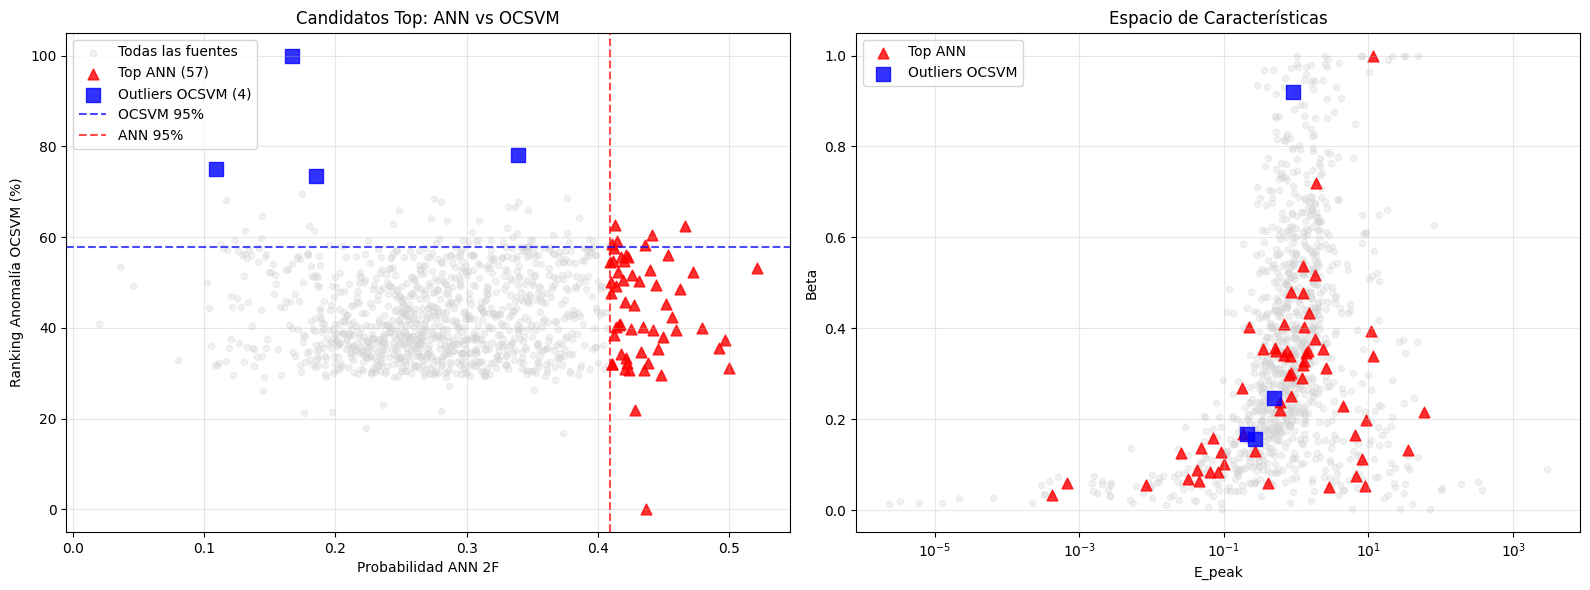

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Scatter enfocado en candidatos
ax1 = axes[0]
# Todas las fuentes en gris
ax1.scatter(comparison_df['ANN_Prob_Mean'], comparison_df['OCSVM_Anomaly_Rank'], 
           alpha=0.3, s=20, c='lightgray', label='Todas las fuentes')

# Top ANN en rojo
ax1.scatter(top_ann_candidates['ANN_Prob_Mean'], top_ann_candidates['OCSVM_Anomaly_Rank'],
           s=60, c='red', marker='^', alpha=0.8, label=f'Top ANN ({len(top_ann_candidates)})')

# Outliers OCSVM en azul
if len(ocsvm_outliers) > 0:
    ax1.scatter(ocsvm_outliers['ANN_Prob_Mean'], ocsvm_outliers['OCSVM_Anomaly_Rank'],
               s=100, c='blue', marker='s', alpha=0.8, label=f'Outliers OCSVM ({len(ocsvm_outliers)})')

# Solapamientos en verde (si existen)
if overlap_1:
    overlap_data_1 = comparison_df[comparison_df['Source_ID'].isin(overlap_1)]
    ax1.scatter(overlap_data_1['ANN_Prob_Mean'], overlap_data_1['OCSVM_Anomaly_Rank'],
               s=150, c='green', marker='*', alpha=1.0, 
               label=f'Consenso ({len(overlap_1)})', edgecolor='black', linewidth=1)

ax1.axhline(ocsvm_threshold, color='blue', linestyle='--', alpha=0.7, label=f'OCSVM 95%')
ax1.axvline(ann_threshold, color='red', linestyle='--', alpha=0.7, label=f'ANN 95%')
ax1.set_xlabel('Probabilidad ANN 2F')
ax1.set_ylabel('Ranking Anomalía OCSVM (%)')
ax1.set_title('Candidatos Top: ANN vs OCSVM')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Feature space con candidatos destacados
ax2 = axes[1]
# Todas las fuentes
ax2.scatter(comparison_df['E_peak'], comparison_df['Beta'], 
           alpha=0.3, s=20, c='lightgray')

# Top ANN
ax2.scatter(top_ann_candidates['E_peak'], top_ann_candidates['Beta'],
           s=60, c='red', marker='^', alpha=0.8, label=f'Top ANN')

# Outliers OCSVM  
if len(ocsvm_outliers) > 0:
    ax2.scatter(ocsvm_outliers['E_peak'], ocsvm_outliers['Beta'],
               s=100, c='blue', marker='s', alpha=0.8, label=f'Outliers OCSVM')

# Consenso
if overlap_1:
    overlap_data_1 = comparison_df[comparison_df['Source_ID'].isin(overlap_1)]
    ax2.scatter(overlap_data_1['E_peak'], overlap_data_1['Beta'],
               s=150, c='green', marker='*', alpha=1.0, 
               label=f'Consenso', edgecolor='black', linewidth=1)

ax2.set_xlabel('E_peak')
ax2.set_ylabel('Beta')
ax2.set_xscale('log')
ax2.set_title('Espacio de Características')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [44]:
# Guardar candidatos de interés
if overlap_1:
    overlap_df_1 = comparison_df[comparison_df['Source_ID'].isin(overlap_1)]
    overlap_df_1.to_csv('../data/results/comparisons/2F/consensus_candidates_strict_2f.csv', index=False)

if overlap_2:
    overlap_df_2 = comparison_df[comparison_df['Source_ID'].isin(overlap_2)]
    overlap_df_2.to_csv('../data/results/comparisons/2F/consensus_candidates_relaxed_2f.csv', index=False)

# Guardar listas de candidatos top
top_ann_candidates.to_csv('../data/results/comparisons/2F/top_ann_candidates_2f.csv', index=False)
if len(ocsvm_outliers) > 0:
    ocsvm_outliers.to_csv('../data/results/comparisons/2F/ocsvm_outliers_2f.csv', index=False)

print(f"\nRESUMEN FINAL:")
print(f"✓ Datos alineados correctamente por posición")
print(f"✓ Top candidatos ANN identificados: {len(top_ann_candidates)}")
print(f"✓ Anomalías OCSVM identificadas: {len(ocsvm_outliers)} outliers + {len(top_ocsvm_anomalies)} top rankings")
print(f"✓ Solapamiento estricto (outliers): {len(overlap_1)} fuentes")
print(f"✓ Solapamiento relajado (top rankings): {len(overlap_2)} fuentes")

if len(overlap_1) > 0 or len(overlap_2) > 0:
    print(f"Hay candidatos de consenso")
else:
    print(f"⚠ No hay consenso directo")


RESUMEN FINAL:
✓ Datos alineados correctamente por posición
✓ Top candidatos ANN identificados: 57
✓ Anomalías OCSVM identificadas: 4 outliers + 57 top rankings
✓ Solapamiento estricto (outliers): 0 fuentes
✓ Solapamiento relajado (top rankings): 6 fuentes
Hay candidatos de consenso
